# Group 10 Project Proposal
#### Authors: Waris Bhatia, Lucy Liu, Yolanda Wu, Caroline Zhang

In [1]:
library(tidyverse)
library(infer)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Preliminary Results

First, let's read the heart disease dataset into R and have a glimpse of our data.

In [2]:
# Read the dataset into R
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

# Rename the column names
colnames(heart) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

head(heart)

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


Our dataset looks almost tidy and clean. The only thing we will do is to:  
- filter out the NA values  
- convert the `ca` and `thal` columns into numeric first and remove decimals
- convert the categorical variables including `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, `num` from numeric to character

In [13]:
heart <- heart %>% 
    drop_na() %>%
    mutate_at(c("ca", "thal"), as.numeric) %>%
    mutate_at(c(2, 3, 6, 7, 9, 11:14), as.character)

head(heart)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3


Now we have a clean and tidy dataframe and we are ready to plot the revevant raw data.

Since we would like to investigate whether the average cholesterol level differ in gender, only two variables will be used in our further analysis, which are `chol` (serum cholesterol in mg/dl) and `sex` (1 = male, 0 = female). Let's select these two columns out.  

In [15]:
chol_sex <- heart %>%
    select(sex, chol)
head(chol_sex)

sex,chol
<chr>,<dbl>
1,286
1,229
1,250
0,204
1,236
0,268


We choose histogram to plot the cholesterol level distribution so that we can have a clear view of the distribution between female and male. It's also helpful for us to select the most appropriate parameters. 

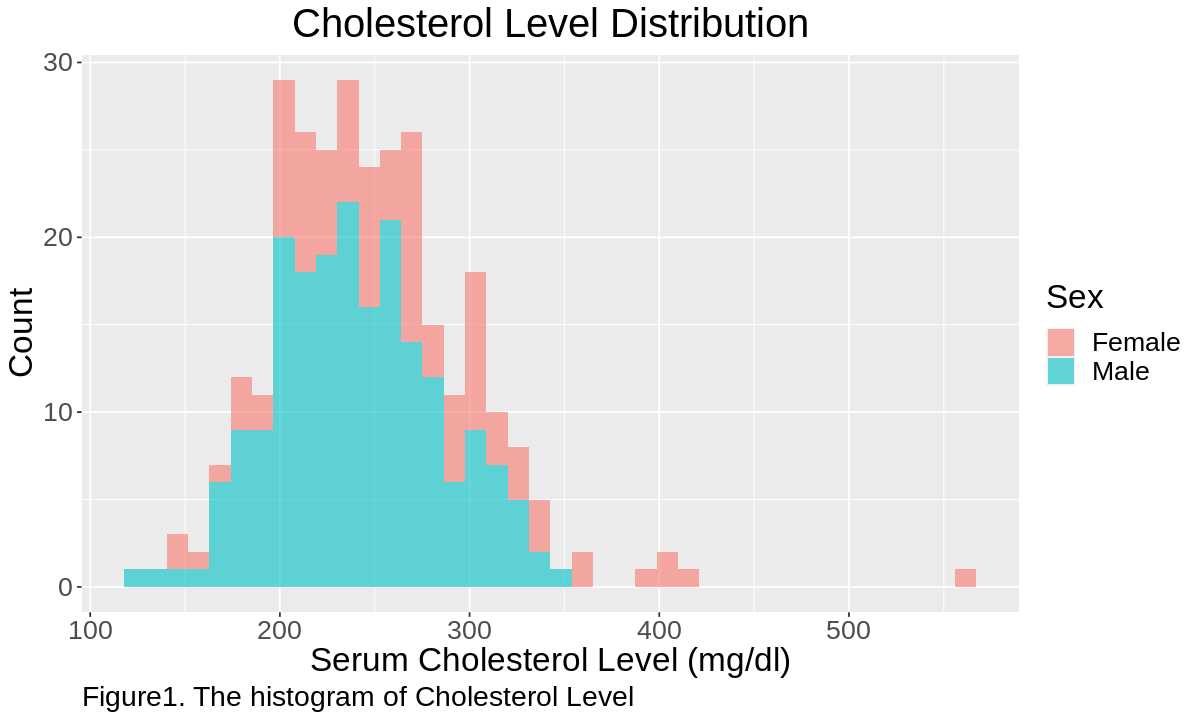

In [40]:
# set the plot size
options(repr.plot.width = 10, repr.plot.height = 6)

# create the histogram
chol_hist <- chol_sex %>%
    ggplot(aes(x = chol, fill = sex)) +
    geom_histogram(bins=40, alpha = 0.6) +
    labs(x = "Serum Cholesterol Level (mg/dl)", 
         y = "Count", 
         fill = "Sex", 
         title = "Cholesterol Level Distribution", 
         caption = "Figure1. The histogram of Cholesterol Level") +
    theme(text = element_text(size = 20), 
          plot.caption = element_text(size = 17, hjust = 0), 
          plot.title = element_text(hjust = 0.5)) +
    scale_fill_discrete(labels = c("Female", "Male"))

chol_hist

As we can see from Figure1, both male and female have similar bell-shaped distributions centered around 250 mg/dl with close range. It's hard to tell which group has a relative higher cholesterol level so hypothesis tests are required to answer our question.

Besides, there are some extreme outliers in female's distribution will cause over-estimate of mean or standard deviation of female cholesterol levels. Thus, our group decide to use median and interquartile range as interested parameters for further comparison. 

Let's take a look at the estimates of median and interquartile range across female and male in our sample. 

In [65]:
chol_sex_estimates <- chol_sex %>%
    group_by(sex) %>%
    summarize(median = median(chol),
              interquartile = IQR(chol)) %>%
    cbind(sex_label = c("female", "male")) %>% 
    relocate(sex_label, .before = sex)
          
chol_sex_estimates

sex_label,sex,median,interquartile
<chr>,<chr>,<dbl>,<dbl>
female,0,255.0,87.50
male,1,236.5,59.75


From above table, we noticed that female has both higher median and interquartile range than male's. Let's plot these estimates into a side-by-side boxplot for comparison. 

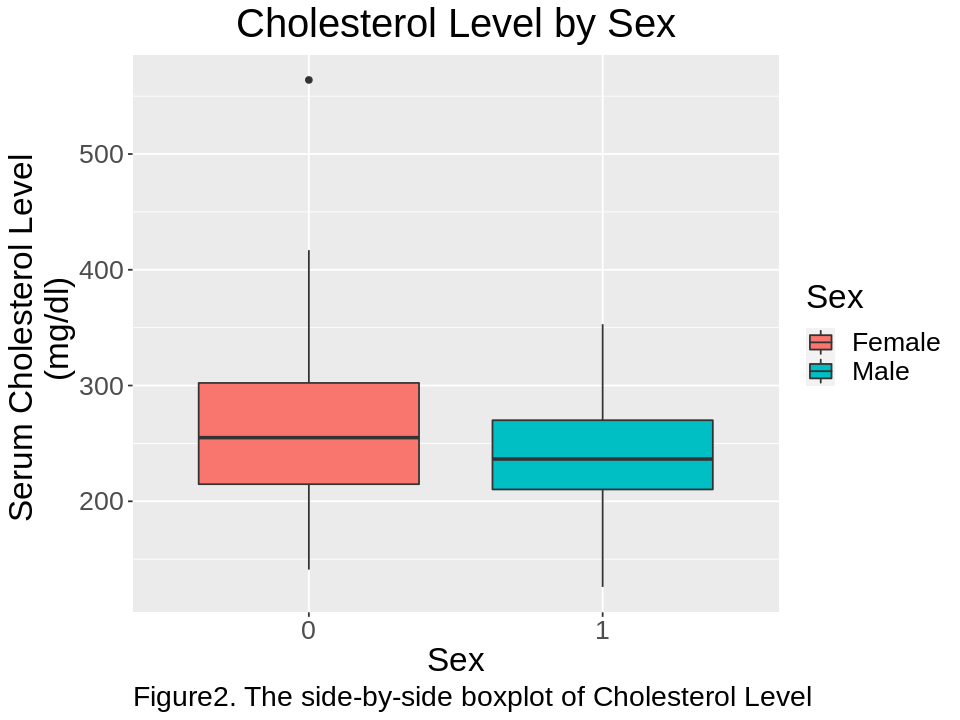

In [62]:
# set the plot size
options(repr.plot.width = 8, repr.plot.height = 6)

# create a side-by-side boxplot between male and female
chol_boxplot <- chol_sex %>%
    ggplot(aes(x=sex, y=chol, fill=sex)) +
    geom_boxplot() +
    labs(x = "Sex", 
         y = "Serum Cholesterol Level \n\ (mg/dl)", 
         fill = "Sex", 
         title = "Cholesterol Level by Sex", 
         caption = "Figure2. The side-by-side boxplot of Cholesterol Level") +
    theme(text = element_text(size = 20), 
          plot.caption = element_text(size = 17, hjust = 0), 
          plot.title = element_text(hjust = 0.5)) +
    scale_fill_discrete(labels = c("Female", "Male"))

chol_boxplot